# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm.auto as tqdm
%matplotlib widget

In [2]:
def grab(x):
    """Convert torch tensor to numpy array"""
    return x.detach().cpu().numpy()

# Phi4 theory

We will use "torch.roll" to compute terms like $\phi_x \phi_{x+\hat{\mu}}$. A little demo:

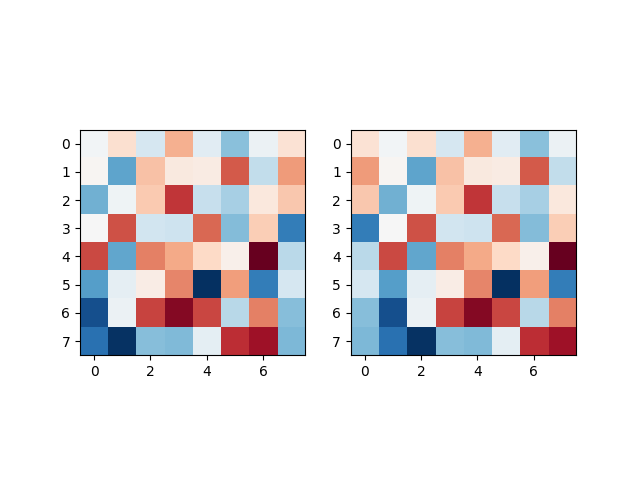

In [3]:
fig, axes = plt.subplots(1, 2)
torch.manual_seed(1234)
phi = torch.randn(size=(8, 8))
axes[0].imshow(grab(phi), cmap='RdBu')
axes[1].imshow(grab(torch.roll(phi, 1, dims=1)), cmap='RdBu')
plt.show()

Lattice action for quartic $\phi^4$ theory, using parameterization in [hep-lat/0506002](http://arxiv.org/abs/hep-lat/0506002)
$$
\begin{aligned}
S(\phi) &= \sum_x \left\{
\frac{m^2}{2} \phi_x^2 + \frac{\lambda}{4!} \phi_x^4 +
\frac{1}{2} \sum_{\mu} \phi_x (2 \phi_x - \phi_{x+\hat{\mu}} - \phi_{x-\hat{\mu}})
\right\} \\
&= \sum_x \left \{
(N_d + \frac{m^2}{2}) \phi_x^2 + \frac{\lambda}{4!} \phi_x^4 - \sum_\mu \phi_x \phi_{x+\hat{\mu}}
\right\}
\end{aligned}
$$

In [4]:
class Phi4Action:
    def __init__(self, m2, lam):
        self.m2 = m2
        self.lam = lam
        self.grad = torch.func.grad(self.value)
    def value(self, phi):
        # phi.shape = (Lx, Ly, ...)
        Nd = len(phi.shape)
        S = ((Nd + self.m2/2) * phi**2 + (self.lam/24) * phi**4).sum()
        for mu in range(Nd):
            phi_fwd = torch.roll(phi, -1, dims=mu)
            S -= (phi * phi_fwd).sum()
        return S

In [5]:
torch.manual_seed(1234)
phi = torch.randn(size=(8, 8))
action = Phi4Action(1., 0.)
s = [grab(action.value(phi))]
for _ in range(1000):
    phi -= 0.01*action.grad(phi)
    s.append(grab(action.value(phi)))
s = np.array(s)

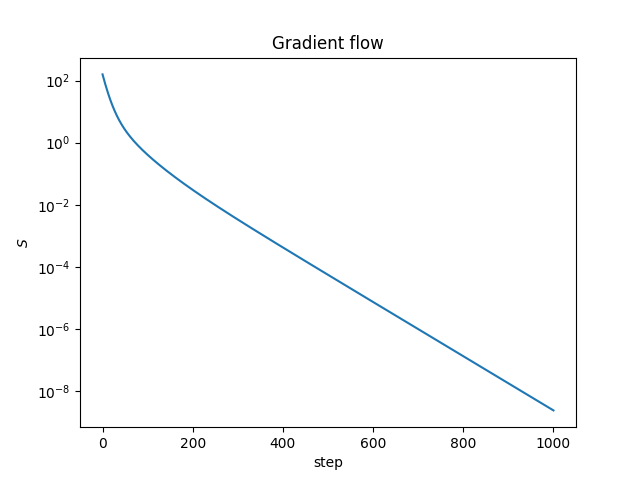

In [6]:
fig, ax = plt.subplots(1,1)
ax.set_title('Gradient flow')
ax.plot(s)
ax.set_ylabel(r'$S$')
ax.set_xlabel('step')
ax.set_yscale('log')
plt.show()

# HMC

Simulate molecular dynamics evolution:
$$
\dot{\phi} = \pi, \qquad
\dot{\pi} = -\nabla S(\phi)
$$

In [7]:
def leapfrog_update(phi, pi, action, *, dt, n_leap):
    phi += (dt/2)*pi
    for _ in range(n_leap-1):
        pi -= dt*action.grad(phi)
        phi += dt*pi
    pi -= dt*action.grad(phi)
    phi += (dt/2)*pi

In [8]:
phi0 = torch.randn(size=(8,8))
pi0 = torch.randn(size=(8,8))
action = Phi4Action(1., 0.)
t = 1.0
deltas = []
dts = []
for n_leap in [10, 25, 50, 100, 250, 500]:
    dt = t / n_leap
    phi = phi0.clone()
    pi = pi0.clone()
    H0 = action.value(phi) + (pi**2/2).sum()
    leapfrog_update(phi, pi, action, dt=dt, n_leap=n_leap)
    H1 = action.value(phi) + (pi**2/2).sum()
    dts.append(dt)
    deltas.append(grab(H1 - H0))

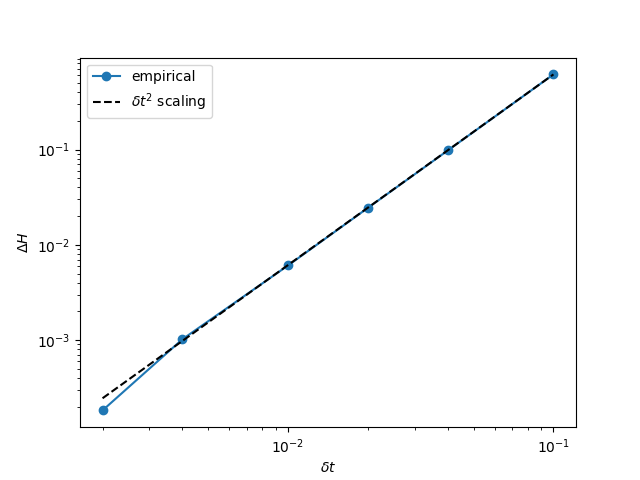

In [9]:
fig, ax = plt.subplots(1,1)
ax.plot(dts, deltas, marker='o', label=r'empirical')
dt_plot = np.linspace(np.min(dts), np.max(dts))
thy_scaling = deltas[0]*(dt_plot/dts[0])**2
ax.plot(dt_plot, thy_scaling, linestyle='--', color='k', label=r'$\delta t^2$ scaling')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$\Delta H$')
ax.set_xlabel(r'$\delta t$')
plt.show()

# MCMC and freezing

For $m^2 = -0.5$, we expect the Z2 symmetry breaking transition around $\lambda \approx 2$, with $\lambda < \lambda_c$ in the broken phase, $\lambda > \lambda_c$ in the symmetric phase. See [hep-lat/0506002](http://arxiv.org/abs/hep-lat/0506002)

<img src="figs/phi4_phase_diagram.png" width="300px"/>

In [10]:
def run_hmc(action, *, n_therm, n_iter, n_meas, dt=0.10, n_leap=10):
    torch.manual_seed(1234)
    phi = 0.1*torch.randn((8, 8)) # warm start
    S = action.value(phi)
    acc = 0
    tot = 0
    meas = []
    for i in tqdm.tqdm(range(-n_therm, n_iter)):
        new_phi = phi.clone()
        pi = torch.randn_like(phi)
        K = (pi**2/2).sum()
        leapfrog_update(new_phi, pi, action, dt=dt, n_leap=n_leap)
        Sp = action.value(new_phi)
        Kp = (pi**2/2).sum()
        dH = grab(Sp + Kp - S - K)
        tot += 1
        if np.random.random() < np.exp(-dH): # accept
            phi = new_phi
            S = Sp
            acc += 1
        if i >= 0 and (i+1)%n_meas == 0:
            meas.append(grab(phi.mean()))
            # print(f'Acc {100.0*acc/tot:.2f}')
    return dict(meas=np.stack(meas))

In [11]:
actBroken = Phi4Action(m2=-0.5, lam=1.5)
actSymm = Phi4Action(m2=-0.5, lam=4.5)

In [12]:
resBroken = run_hmc(actBroken, n_therm=100, n_iter=1000, n_meas=1, dt=0.05, n_leap=50)

  0%|          | 0/1100 [00:00<?, ?it/s]

In [13]:
resSymm = run_hmc(actSymm, n_therm=100, n_iter=1000, n_meas=1, dt=0.05, n_leap=20)

  0%|          | 0/1100 [00:00<?, ?it/s]

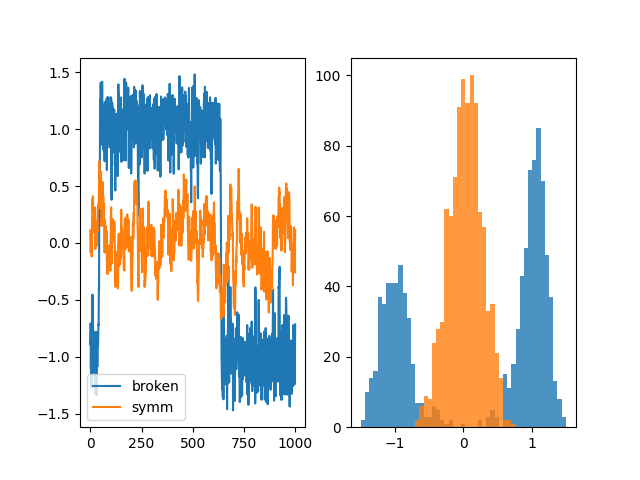

In [14]:
fig, axes = plt.subplots(1, 2)
ax = axes[0]
ax.plot(resBroken['meas'], label='broken')
ax.plot(resSymm['meas'], label='symm')
ax.legend()
ax = axes[1]
ax.hist(resBroken['meas'], bins=np.linspace(-1.5, 1.5), alpha=0.8)
ax.hist(resSymm['meas'], bins=np.linspace(-1.5, 1.5), alpha=0.8)
plt.show()

**EXERCISE:**

In [17]:
def rho(meas, *, tmax):
    rho_t = [1.0] # special case for first point
    O2 = np.mean(meas**2)
    for t in range(1, tmax):
        rho_t.append(np.mean(meas[t:] * meas[:-t]) / O2)
    return np.stack(rho_t)

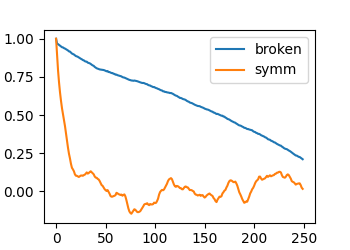

In [27]:
fig, ax = plt.subplots(1,1, figsize=(3.5, 2.5))
ax.plot(rho(resBroken['meas'], tmax=250), label='broken')
ax.plot(rho(resSymm['meas'], tmax=250), label='symm')
ax.legend()
ax.set_ylabel(r'$\rho$')
ax.set_xlabel(r'$t$')
plt.show()

If the Markov chain is really tunneling according to a Poisson process with rate parameter $r$, we expect at small values of $t$ that the probability of the Markov chain to be at its **original minimum** (WLOG $+v$) is $e^{-r t}$ while the probability to be in the **other minimum** ($-v$) is $1 - e^{-r t}$. The value of $\rho$ is then
$$
\rho(t) \sim e^{-r t} \frac{v^2}{v^2} + (1-e^{-r t}) \frac{v(-v)}{v^2} = 2 e^{-r t} - 1.
$$
For example for $r = 0.01$, we expect a reasonable approximation for $t \lesssim 1/r = 100$, and the scaling looks like:

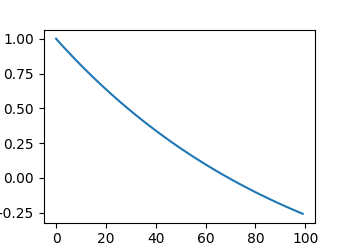

In [33]:
# example plot for r = 0.1
fig, ax = plt.subplots(1,1, figsize=(3.5, 2.5))
ts = np.arange(100)
ax.plot(ts, 2*np.exp(-0.01*ts) - 1)
plt.show()

What we are missing is the transition probability to tunnel **again** into the original minimum, or to tunnel three times, and so on. I leave working this out exactly as an extra exercise!

In [22]:
def tint(rho):
    return 0.5 + np.cumsum(rho)

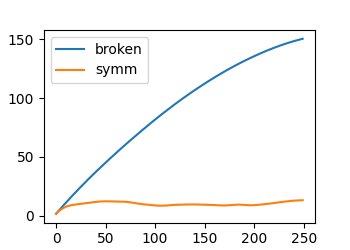

In [28]:
fig, ax = plt.subplots(1,1, figsize=(3.5, 2.5))
ax.plot(tint(rho(resBroken['meas'], tmax=250)), label='broken')
ax.plot(tint(rho(resSymm['meas'], tmax=250)), label='symm')
ax.set_ylabel(r'$\tau_{\mathrm{int}}$')
ax.set_xlabel(r'$t_{\mathrm{max}}$')
ax.legend()
plt.show()

# Sampling using flows

Let's concoct a synthetic example of a flow, to see how it can result in sampling interesting distributions. Prior distribution
$$
r(x_0, x_1) = \frac{1}{2\pi} \exp(-(x_0^2 + x_1^2)/2)
$$
and flow $\dot{x} = b(x)$ to be integrated over $t \in [0,1]$. For this example, we use a velocity designed to create a double-peaked distribution
$$
b(x) = \begin{pmatrix}
x_0 e^{-x_0^2/2} \\ - x_1
\end{pmatrix}
$$
for which $\nabla \cdot b = (1 - x_0^2) e^{-x_0^2/2} - 1$.

/var/folders/82/6ffg_k297qg8kv_fyhl4g4g80000gn/T/ipykernel_60267/1225550503.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1, figsize=(3.5, 2.5))


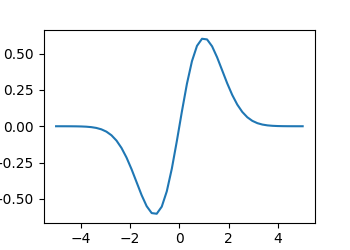

In [35]:
fig, ax = plt.subplots(1,1, figsize=(3.5, 2.5))
xs = np.linspace(-5, 5)
ax.plot(xs, xs*np.exp(-xs**2/2))
ax.set_ylabel(r'$dx_0/dt$')
ax.set_xlabel(r'$x_0$')
plt.show()

In [36]:
class ToyVelocity:
    def value(self, x, t):
        """how the samples move"""
        x0, x1 = x
        return torch.stack([2*x0*torch.exp(-x0**2/2), -x1])
    def div(self, x, t):
        """how the density squishes/stretches"""
        x0, x1 = x
        w = 2*torch.exp(-x0**2/2)
        return (1 - x0**2)*w - 1

def flow(x, velocity, *, n_step, tf=1.0, inverse=False):
    dt = tf/n_step
    ts = dt*torch.arange(n_step)
    logJ = torch.zeros_like(x[0])
    sign = 1
    if inverse:
        sign = -1
        ts = reversed(ts)
    for t in ts:
        # transport samples
        x += sign * dt * velocity.value(x, t)
        # estimate change of measure
        logJ += dt * velocity.div(x, t)
    return x, logJ

In [37]:
velocity = ToyVelocity()
# flow_single = lambda x: flow(x, velocity, n_step=25)
flow_batch = torch.func.vmap(flow, in_dims=(0,None))
xr = torch.randn((4096,2))
xa, logJa = flow_batch(xr.clone(), velocity, n_step=33, tf=0.33)
xb, logJb = flow_batch(xr.clone(), velocity, n_step=66, tf=0.66)
xc, logJc = flow_batch(xr.clone(), velocity, n_step=100, tf=1.0)

Change of measure from flow $x = f(x_r)$ is given by
$$
\log{q}(x) = \log{r}(x_r) - \log{J}_f
$$
To remember the sign: **stretching** ($\log{J}_f > 0$) **reduces** the density.

In [38]:
def eval_logq(x, tf):
    xr, logJ = flow_batch(x.reshape(-1, 2).clone(), velocity, n_step=100, tf=tf, inverse=True)
    logr = -(xr**2/2).sum(-1) - np.log(2*np.pi)
    assert logr.shape == logJ.shape
    print(f'flat shape {logr.shape} -> full shape {x.shape[:-1]}')
    return (logr - logJ).reshape(x.shape[:-1])

flat shape torch.Size([2601]) -> full shape torch.Size([51, 51])
flat shape torch.Size([2601]) -> full shape torch.Size([51, 51])
flat shape torch.Size([2601]) -> full shape torch.Size([51, 51])
flat shape torch.Size([2601]) -> full shape torch.Size([51, 51])


/Users/gkanwar/projects/flow-lectures/venv/lib/python3.13/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/var/folders/82/6ffg_k297qg8kv_fyhl4g4g80000gn/T/ipykernel_60267/3285920676.py:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  axes[1,0].contourf(x_mesh[...,0], x_mesh[...,1], np.exp(logq_0))
/var/folders/82/6ffg_k297qg8kv_fyhl4g4g80000gn/T/ipykernel_60267/3285920676.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  axes[1,1].contourf(x_mesh[...,0], x_mesh[...,1], np.exp(logq_a))
/var/folders/82/6ffg_k297qg8kv_fyhl4g4g80000

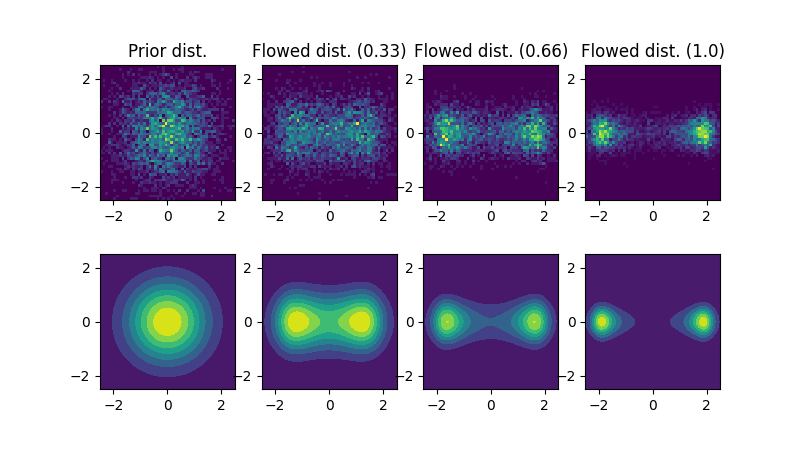

In [39]:
fig, axes = plt.subplots(2,4, figsize=(8,4.5))
bins=np.linspace(-2.5, 2.5, num=51)

# samples
axes[0,0].hist2d(grab(xr)[:,0], grab(xr)[:,1], bins=bins)
axes[0,0].set_title('Prior dist.')
axes[0,1].hist2d(grab(xa)[:,0], grab(xa)[:,1], bins=bins)
axes[0,1].set_title('Flowed dist. (0.33)')
axes[0,2].hist2d(grab(xb)[:,0], grab(xb)[:,1], bins=bins)
axes[0,2].set_title('Flowed dist. (0.66)')
axes[0,3].hist2d(grab(xc)[:,0], grab(xc)[:,1], bins=bins)
axes[0,3].set_title('Flowed dist. (1.0)')

# density
x_mesh = torch.stack(torch.meshgrid(torch.tensor(bins), torch.tensor(bins)), dim=-1)
# x_mesh = x_mesh.flatten(0,1)
logq_0 = eval_logq(x_mesh, tf=0.0)
logq_a = eval_logq(x_mesh, tf=0.33)
logq_b = eval_logq(x_mesh, tf=0.66)
logq_c = eval_logq(x_mesh, tf=1.0)
x_mesh = grab(x_mesh)
axes[1,0].contourf(x_mesh[...,0], x_mesh[...,1], np.exp(logq_0))
axes[1,1].contourf(x_mesh[...,0], x_mesh[...,1], np.exp(logq_a))
axes[1,2].contourf(x_mesh[...,0], x_mesh[...,1], np.exp(logq_b))
axes[1,3].contourf(x_mesh[...,0], x_mesh[...,1], np.exp(logq_c))

for ax in axes.flatten():
    ax.set_aspect(1.0)
plt.show()

**EXERCISE:** Let's implement the mixture $\log{p}$. I will implement this to act on Pytorch tensors, but you could also implement this using numpy.

In [82]:
def eval_logp(x, mu, sigma):
    return torch.log(
        0.5*torch.exp(-torch.sum((x-mu)**2/(2*sigma**2), dim=-1)) +
        0.5*torch.exp(-torch.sum((x+mu)**2/(2*sigma**2), dim=-1))) - np.log(2*np.pi*sigma**2)

flat shape torch.Size([2601]) -> full shape torch.Size([51, 51])


/var/folders/82/6ffg_k297qg8kv_fyhl4g4g80000gn/T/ipykernel_60267/585426585.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  axes[0].contourf(x_mesh[...,0], x_mesh[...,1], np.exp(logq))
/var/folders/82/6ffg_k297qg8kv_fyhl4g4g80000gn/T/ipykernel_60267/585426585.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  axes[1].contourf(x_mesh[...,0], x_mesh[...,1], np.exp(logp))


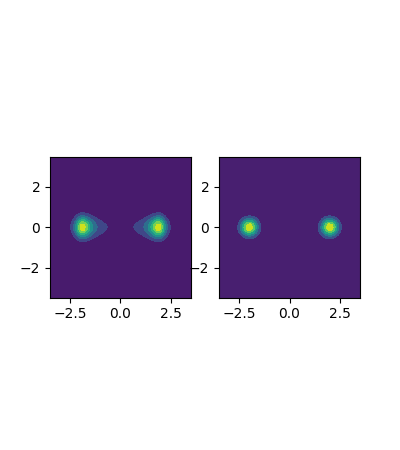

In [85]:
fig, axes = plt.subplots(1,2, figsize=(4,4.5))
bins=np.linspace(-3.5, 3.5, num=51)

# this is close...
mu = torch.tensor([2.0, 0.0])
sigma = 0.3

# density
x_mesh = torch.stack(torch.meshgrid(torch.tensor(bins), torch.tensor(bins)), dim=-1)
# x_mesh = x_mesh.flatten(0,1)
logq = eval_logq(x_mesh, tf=1.0)
logp = eval_logp(x_mesh, mu=mu, sigma=sigma) # make sure to give the numpy 
x_mesh = grab(x_mesh)
axes[0].contourf(x_mesh[...,0], x_mesh[...,1], np.exp(logq))
axes[1].contourf(x_mesh[...,0], x_mesh[...,1], np.exp(logp))

for ax in axes.flatten():
    ax.set_aspect(1.0)
plt.show()

In [86]:
def eval_ess(w):
    return np.mean(w)**2 / np.mean(w**2)

flat shape torch.Size([100]) -> full shape torch.Size([100])
np.mean(w)=np.float32(0.8837872)
ess=np.float32(0.57667154)
flat shape torch.Size([1000]) -> full shape torch.Size([1000])
np.mean(w)=np.float32(1.0009196)
ess=np.float32(0.5888802)
flat shape torch.Size([5000]) -> full shape torch.Size([5000])
np.mean(w)=np.float32(1.007028)
ess=np.float32(0.5885015)
flat shape torch.Size([10000]) -> full shape torch.Size([10000])
np.mean(w)=np.float32(1.0046254)
ess=np.float32(0.59181553)
flat shape torch.Size([20000]) -> full shape torch.Size([20000])
np.mean(w)=np.float32(1.0161135)
ess=np.float32(0.59406346)


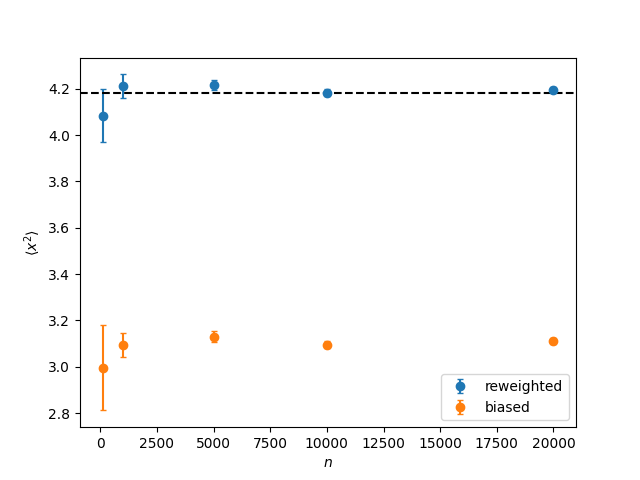

In [111]:
from util import bootstrap
def estimate_x2():
    torch.manual_seed(3456)
    # samples from q, copying code from lecture
    flow_batch = torch.func.vmap(flow, in_dims=(0,None))
    meas_x2 = []
    meas_x2_biased = []
    ns = np.array([100, 1000, 5000, 10000, 20000])
    for n in ns:
        xr = torch.randn((n,2))
        x, logJ = flow_batch(xr.clone(), velocity, n_step=100, tf=1.0)
        logq = grab(eval_logq(x, tf=1.0))
        sigma = 0.3
        mu = torch.tensor([2.0, 0.0])
        logp = grab(eval_logp(x, mu=mu, sigma=sigma))
        w = np.exp(logp - logq)
        print(f'{np.mean(w)=}') # this should be close to 1
        ess = eval_ess(w)
        print(f'{ess=}') # should be non-zero
        O = grab((x**2).sum(-1))
        meas_x2_biased.append(bootstrap(O, Nboot=1000, f=lambda O: np.mean(O)))
        meas_x2.append(bootstrap(w, O, Nboot=1000, f=lambda w,O: np.mean(w*O)/np.mean(w)))
    meas_x2 = np.stack(meas_x2)
    meas_x2_biased = np.stack(meas_x2_biased)
    true_x2 = 2*sigma**2 + grab((mu**2).sum(-1))
    fig, ax = plt.subplots(1,1)
    mean_x2 = meas_x2[:,0]
    err_x2 = meas_x2[:,1]
    ax.errorbar(ns, mean_x2, yerr=err_x2, linestyle='', capsize=2, marker='o', label='reweighted')
    ax.errorbar(ns, meas_x2_biased[:,0], yerr=meas_x2_biased[:,1], linestyle='', capsize=2, marker='o', label='biased')
    ax.axhline(true_x2, linestyle='--', color='k')
    ax.legend()
    ax.set_xlabel(r'$n$')
    ax.set_ylabel(r'$\langle x^2 \rangle$')
    plt.show()
estimate_x2()

We see a small bias outside of the estimated errors on some points. This is likely just statistical fluctuation, but could also arise from a long tail on the reweighting factors. With sufficiently many samples, we are guaranteed to converge to the correct answer.